___How would you harness the additional historical data available through the underlying index to calculate expected returns of the ETF more accurately?___

Files: 
    
- AAXJ.csv
- NDUECAXJ.csv

1. https://stackoverflow.com/questions/65336789/numpy-build-fail-in-m1-big-sur-11-1
1. https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html
1. https://www.mlq.ai/python-for-finance-time-series-analysis/
1. https://stackoverflow.com/questions/34159342/extrapolate-pandas-dataframe/35960833
1. https://en.wikipedia.org/wiki/Extrapolation
1. https://repository.upenn.edu/cgi/viewcontent.cgi?article=1179&context=marketing_papers
1. https://www.kaggle.com/pierpaolo28/stock-market-analysis-and-time-series-prediction
1. https://www.hindawi.com/journals/jam/2014/614342/

- p, d, q
- machine learning

         date     msci    aaxj
0    Dec-2000  100.000     NaN
1    Jan-2001  112.872     NaN
2    Feb-2001  107.526     NaN
3    Mar-2001   95.302     NaN
4    Apr-2001   95.441     NaN
..        ...      ...     ...
234  Jun-2020  485.266  85.375
235  Jul-2020  526.496  92.373
236  Aug-2020  545.181  95.977
237  Sep-2020  536.990  95.249
238  Oct-2020  551.992  97.014

[239 rows x 3 columns]


<AxesSubplot:>

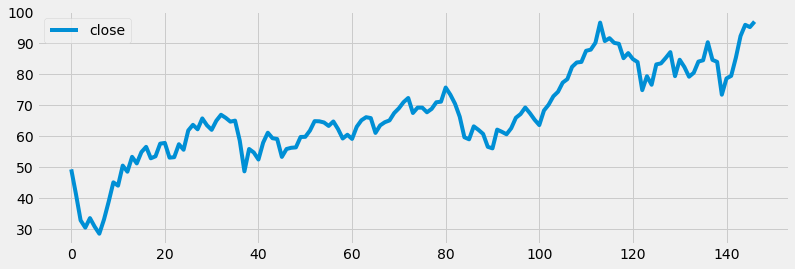

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


plt.rcParams["figure.figsize"] = (12, 4)
plt.style.use('fivethirtyeight')

aaxj = pd.read_csv('csv/AAXJ.csv')
msci = pd.read_csv('csv/NDUECAXJ.csv') 

# ax = aaxj.plot()
# msci.plot(ax=ax)

data = pd.merge(msci, aaxj, how='outer', on='Date')
data.columns = ['date', 'msci', 'aaxj']
data.set_index('date')

aaxj.columns = ['date', 'close']
msci.columns = ['date', 'close']

print(data)
aaxj.plot()

## Extend AAXJ historical data by proxy

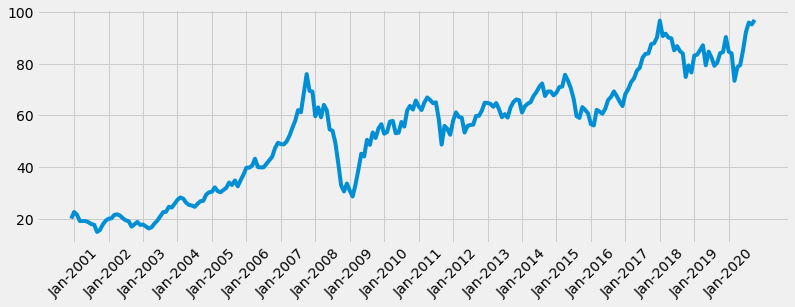

In [7]:
data.loc[data["aaxj"].isnull(),'aaxj'] = 0.2 * data['msci']

plt.xticks(np.arange(1, 240, 12), rotation=45)
plt.plot(data['date'], data['aaxj'])



## Time series forecasting

KeyError: 'close'

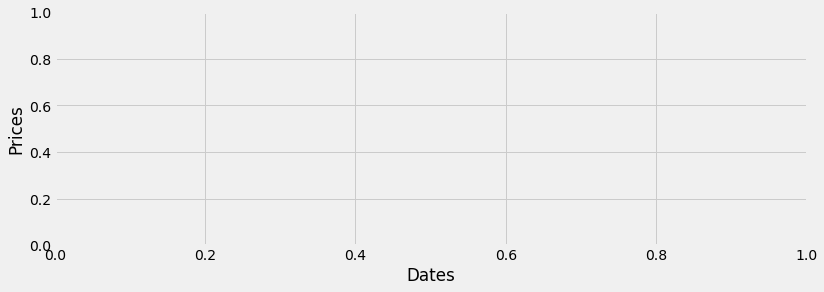

In [14]:
train_data, test_data = aaxj[0:int(len(aaxj)*0.8)], aaxj[int(len(aaxj)*0.8):]

plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data['close'], 'blue', label='Training Data')
plt.plot(test_data['close'], 'green', label='Testing Data')
plt.xticks(np.arange(0, len(aaxj), 12), aaxj['date'][0:len(aaxj):12], rotation=45)
plt.legend()


<class 'list'>


/Users/vongst/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error: 20.908
Symmetric mean absolute percentage error: 7.332


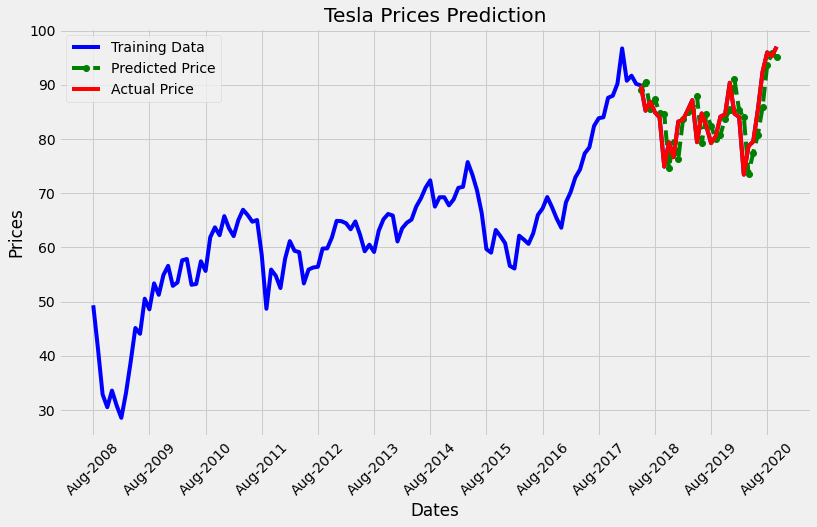

In [13]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

train_ar = train_data['close'].values
test_ar = test_data['close'].values

# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

plt.figure(figsize=(12,7))
plt.plot(aaxj['close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['close'], color='red', label='Actual Price')
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,147, 12), aaxj['date'][0:147:12], rotation=45)
plt.legend()